  0%|          | 0/40 [00:00<?, ?it/s]

init weight from ../model/VNet_CTM/iter_6001.pth
1006763 :


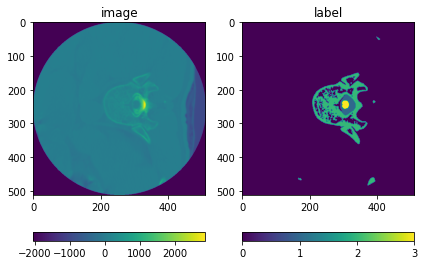

> <ipython-input-2-3fc133250e31>(73)predict_and_construct()
     71         pdb.set_trace()
     72         # 灰度标准化
---> 73         image = (image - np.mean(image)) / np.std(image)
     74         image = image.astype(np.float32)
     75 

ipdb> dir(seg_sitk)
['CopyInformation', 'EraseMetaData', 'GetDepth', 'GetDimension', 'GetDirection', 'GetHeight', 'GetITKBase', 'GetMetaData', 'GetMetaDataKeys', 'GetNumberOfComponentsPerPixel', 'GetNumberOfPixels', 'GetOrigin', 'GetPixel', 'GetPixelAsComplexFloat64', 'GetPixelID', 'GetPixelIDTypeAsString', 'GetPixelIDValue', 'GetSize', 'GetSpacing', 'GetWidth', 'HasMetaDataKey', 'IsUnique', 'MakeUnique', 'SetDirection', 'SetMetaData', 'SetOrigin', 'SetPixel', 'SetPixelAsComplexFloat64', 'SetSpacing', 'TransformContinuousIndexToPhysicalPoint', 'TransformIndexToPhysicalPoint', 'TransformPhysicalPointToContinuousIndex', 'TransformPhysicalPointToIndex', '_Image__ipaste', '__GetPixelAsComplexFloat32__', '__GetPixelAsDouble__', '__GetPixelAsFloat__', '__G

ipdb> tmp=np.where(seg[:,:,:,0]==1)
ipdb> tmp
(array([207, 207, 207, ..., 296, 297, 297]), array([264, 265, 266, ..., 256, 253, 254]), array([46, 46, 46, ..., 36, 36, 36]))
ipdb> tmp[0].min()
207
ipdb> tmp[0].min(), tmp[0].max(), tmp[1].min(), tmp[1].max(), tmp[2].min(), tmp[2].max()
(207, 297, 247, 379, 7, 81)
ipdb> tmp.shape
*** AttributeError: 'tuple' object has no attribute 'shape'
ipdb> seg.shape
(512, 446, 82, 3)
ipdb> image.shape
(512, 512, 82)
ipdb> '%d %d %d %d %d %d'%( tmp[0].min(), tmp[0].max(), tmp[1].min(), tmp[1].max(), tmp[2].min(), tmp[2].max() )
'207 297 247 379 7 81'
--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
ipdb> exit
cut image.shape: (512, 512, 82) cut label.shape: (512, 512, 82)


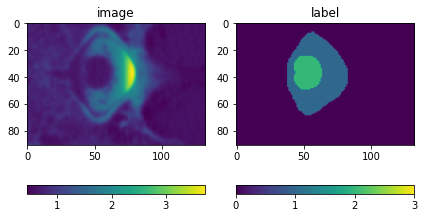

1, 1, 2
np.unique(gt): [0 1 2]
([0.9892657753857307, 0.9320694168188641, 0.8264823572208075], [0.9787595505270124, 0.8727809012102916, 0.7042777433353998], [1.0, 2.8284271247461903, 2.23606797749979], [0.16140372565450115, 0.7004766251473648, 1.0045695973674058])


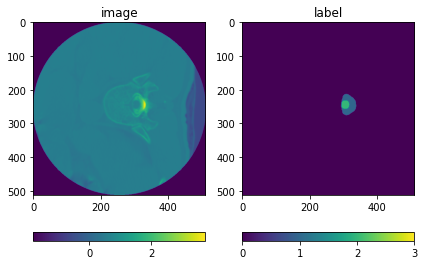

  2%|▎         | 1/40 [1:05:47<42:45:57, 3947.63s/it]

B785777 :


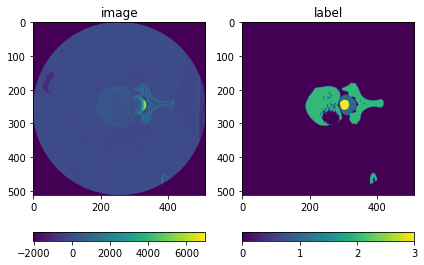

> <ipython-input-2-3fc133250e31>(71)predict_and_construct()
     69 
     70         import pdb
---> 71         pdb.set_trace()
     72         # 灰度标准化
     73         image = (image - np.mean(image)) / np.std(image)

ipdb> exit


  2%|▎         | 1/40 [1:05:56<42:51:33, 3956.23s/it]


BdbQuit: 

In [2]:
import os
import argparse
import torch
from networks.vnet import VNet
from test_util import  predict_and_center_cut_all_case, test_single_case, calculate_metric_percase
import numpy as np
from tensorflow.keras.utils import to_categorical

import sys
sys.path.append('./dataloaders')
from utils import resample_image3D, sitk_onehot_transform, make_out_itk, array_replace, plot_slice_sample

from tqdm import tqdm
import SimpleITK as sitk

# parser = argparse.ArgumentParser()
# parser.add_argument('--root_path', type=str, default='../data/CTM_dataset/unSegmented', help='Folder of Test Set')
# parser.add_argument('--model', type=str,  default='vnet_supervisedonly_dp', help='model_name')
# parser.add_argument('--gpu', type=str,  default='0', help='GPU to use')
# FLAGS = parser.parse_args()
# os.environ['CUDA_VISIBLE_DEVICES'] = FLAGS.gpu
# snapshot_path = "../model/"+FLAGS.model+"/"
# test_save_path = "../model/prediction/"+FLAGS.model+"_post/"


root_path='../data/CTM_dataset/Segmented'
model='VNet_CTM'#'VNet_Binary_CTM'
gpu='0'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu
snapshot_path = "../model/"+model+"/"
# test_save_path = "../model/prediction/unSegmented/"+model+"_post/"
test_save_path = "../model/prediction/reconstruct/"+model
if not os.path.exists(test_save_path):
    os.makedirs(test_save_path)

num_classes = 3#2

with open(root_path + '/../test.list', 'r') as f:
    image_list = f.readlines()
image_list = [os.path.join(root_path,item.replace('\n', ''),"CTM.nrrd") for item in image_list]

def predict_and_construct(
    net,listt,
    stride_xy, stride_z, patch_size, num_classes=1, device="cuda",
    old_replaced="CTM.nrrd"):

    for item in tqdm(listt):
        sample_name = item.split('/')[-2]
        print(sample_name,':')#win系统改为'\\'
        
        # read image
        image_sitk = sitk.ReadImage(item)
        seg_sitk = sitk.ReadImage(item.replace(old_replaced, 'Segmentation.seg.nrrd'))#label_onehot_origin_sitk
        label_sitk = sitk.ReadImage(item.replace(old_replaced, 'Segmentation-label.nrrd'))
        label_onehot_sitk = sitk_onehot_transform(label_sitk)
        
        label_name = [
            'bg',
            seg_sitk.GetMetaData('Segment0_Name'),
            seg_sitk.GetMetaData('Segment1_Name'),
            seg_sitk.GetMetaData('Segment2_Name') 
            ]#人工标注的类别顺序
        
        # get array
        image = sitk.GetArrayFromImage(image_sitk).transpose((2,1,0))#tanspose之后才能与sitk.GetSize匹配
        label_onehot = np.round( sitk.GetArrayFromImage(label_onehot_sitk) ).transpose((2,1,0,3))#tanspose之后才能与sitk.GetSize匹配
        label = sitk.GetArrayFromImage(label_sitk).transpose((2,1,0)).astype('uint8')#np.argmax(label_onehot,axis=-1)
        plot_slice_sample(image,label,np.nonzero(label)[2].max(),fn=False)
        
        # 灰度标准化
        image = (image - np.mean(image)) / np.std(image)
        image = image.astype(np.float32)
        
        ## 调整类别顺序&合并骨头到背景中，注意：是onehot编码
        target_name = ['bg','bone','dura','SC']#目标类别顺序
        idx = [label_name.index(name) for name in target_name]
        assert len(idx)==4,'one or more classes missed'
        label_onehot = label_onehot[:,:,:,idx]

        ## bone归入背景类
        bg = label_onehot[:,:,:,[0,1]].sum(axis=-1)[:,:,:,np.newaxis]
        label_onehot = np.concatenate((bg,label_onehot[:,:,:,2:]),axis=-1)
        assert (np.unique(label_onehot) == [0, 1]).all(), "1: pixel class error"
        ## 转化为非onehot编码以便作图
        label = np.argmax(label_onehot, axis=-1).astype('uint8')

        
        # cut( center cut)
        tempL = np.nonzero(label)
        minx, maxx = np.min(tempL[0]), np.max(tempL[0])
        miny, maxy = np.min(tempL[1]), np.max(tempL[1])
        minz, maxz = np.min(tempL[2]), np.max(tempL[2])
        image_cut = image[minx:maxx+1, miny:maxy+1, minz:maxz+1]
        label_cut = label[minx:maxx+1, miny:maxy+1, minz:maxz+1]
        label_onehot_cut = label_onehot[minx:maxx+1, miny:maxy+1, minz:maxz+1, :]
        print("cut image.shape:",image.shape, "cut label.shape:",label.shape)
        plot_slice_sample(image_cut,label_cut,maxz-minz,fn=False)
        
        
        # predict
        label_cut_pred, score_cut_pred = test_single_case(net, image_cut, stride_xy, stride_z, patch_size, num_classes=num_classes, device="cuda")
        # get metric
        single_metric = calculate_metric_percase(label_cut_pred, label_cut, num_classes)
        print(single_metric)
        
        # 将cut之后的图像的预测值恢复为原图大小：
        tmp = np.zeros(image.shape)
        tmp[minx:maxx+1, miny:maxy+1, minz:maxz+1] = label_cut_pred
        label_pred = tmp.astype('uint8')
        
        label_onehot_pred = to_categorical(label_pred)
        offset = seg_sitk.GetMetaData('Segmentation_ReferenceImageExtentOffset')
        offset = [int(fs) for fs in offset.split()]
        shape = sitk.GetArrayFromImage(seg_sitk).transpose(2,1,0,3).shape
        label_onehot_pred = label_onehot_pred[
            offset[0]:offset[0]+shape[0],
            offset[1]:offset[1]+shape[1],
            offset[2]:offset[2]+shape[2],
            1:
        ].astype('uint8')
        plot_slice_sample(image,label_pred,np.nonzero(label)[2].max(),fn=False)
        
        try:
            # generate sitk object
            label_pred_sitk = sitk.GetImageFromArray(label_pred.transpose(2,1,0))
            label_pred_sitk.CopyInformation(label_sitk)
            label_onehot_pred_sitk = sitk.GetImageFromArray(label_onehot_pred.transpose(2,1,0,3))
            label_onehot_pred_sitk.CopyInformation(seg_sitk)

            # save to nrrd file
            sitk.WriteImage(label_onehot_pred_sitk, item.replace(old_replaced, 'Segmentation-pred.seg.nrrd'))
            sitk.WriteImage(label_pred_sitk, item.replace(old_replaced, 'Segmentation-pred-label.nrrd'))
        except:
            print('case %s:generate asd save sitk error, skip this case'%sample_name)

        
def predict_and_construct_all_case(
    epoch_num, 
    patch_size=(128, 128, 64), 
    stride_xy=64, 
    stride_z=32,
    device='cuda'
):
    
    net = VNet(n_channels=1, n_classes=num_classes, normalization='batchnorm', has_dropout=False).to(device)
    save_mode_path = os.path.join(snapshot_path, 'iter_' + str(epoch_num) + '.pth')
    net.load_state_dict(torch.load(save_mode_path))
    print("init weight from {}".format(save_mode_path))
    net.eval()
    
    predict_and_construct(net,image_list, stride_xy, stride_z, patch_size, num_classes=num_classes, device=device)
    

if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    predict_and_construct_all_case(6001, patch_size=(256, 256, 64), stride_xy=64, stride_z=32, device=device)